# Домашняя работа
### Взять boston house-prices datase (sklearn.datasets.load_boston) и сделать тоже самое для задачи регрессии (попробовать разные алгоритмы, поподбирать параметры, вывести итоговое качество)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

In [3]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
print(load_boston()['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
y = load_boston().target
X = load_boston().data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def metrics(y_test, y_cross, metric_type):
    
    if metric_type == 'RSMLE':
        return (mean_squared_log_error(y_test, y_cross))**0.5
    
    elif metric_type == 'MPE':
        return 100*((abs(y_test - y_cross))/y_test).sum()/len(y_test)
    
    elif metric_type == 'Root absolute error':
        return (mean_absolute_error(y_test, y_cross))**0.5
    
    elif metric_type == 'RMSE':
        return (mean_squared_error(y_test, y_cross))**0.5
    
    elif metric_type == 'Explained variance score':
        return explained_variance_score(y_test, y_cross)
    
    elif metric_type == 'R2 score':
        return r2_score(y_test, y_cross)

## XGBRegressor

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
parameters = {
    'max_depth':range(1, 7, 1),
    'learning_rate':np.arange(0.1, 0.4, 0.1),
}

gsearch1 = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

{'learning_rate': 0.4, 'max_depth': 6}

In [11]:
xgbreg = XGBRegressor(
        max_depth=gsearch1.best_params_['max_depth'],
        learning_rate=gsearch1.best_params_['learning_rate'],
        n_estimators=1000
)

xgbreg.fit(X_train, y_train)

y_test_predict_xgbreg = xgbreg.predict(X_test)

# SVR

In [12]:
parameters = {
    'C': [0.001, 0.01, 0.1, 0.25, 0.5, 5, 10, 50, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1, 2, 3]
}

gsearch2 = GridSearchCV(
            estimator=SVR(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_

{'C': 100, 'degree': 1, 'kernel': 'rbf'}

In [13]:
svrreg = SVR(
        kernel=gsearch2.best_params_['kernel'],
        C=gsearch2.best_params_['C'],
        degree=gsearch2.best_params_['degree'],
)

y_test_predict_svrreg = svrreg.fit(X_train, y_train).predict(X_test)

# GradientBoostingRegressor

In [14]:
parameters = {
    'max_depth':range(1, 7, 1),
    'learning_rate':np.arange(0.1, 0.4, 0.1),
}

gsearch3 = GridSearchCV(
            estimator=GradientBoostingRegressor(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_

{'learning_rate': 0.2, 'max_depth': 3}

In [15]:
gbreg = GradientBoostingRegressor(
        max_depth=gsearch3.best_params_['max_depth'],
        learning_rate=gsearch3.best_params_['learning_rate'],
        n_estimators=1000
)

gbreg.fit(X_train, y_train)
y_test_predict_gbreg = gbreg.predict(X_test)

# LinearRegression (Lasso)

In [31]:
parameters = {
    'alpha':np.arange(0, 1, 0.005),
}

gsearch4 = GridSearchCV(
            estimator=Lasso(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_

{'alpha': 0.025}

In [32]:
lasreg = Lasso(
        alpha=gsearch4.best_params_['alpha']
)

lasreg.fit(X_train, y_train)
y_test_predict_lasreg = lasreg.predict(X_test)

# KNeighborsRegressor

In [18]:
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 7, 9],
    'p': [1, 2],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}

gsearch5 = GridSearchCV(
            estimator=KNeighborsRegressor(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch5.fit(X_train, y_train)
gsearch5.best_params_

{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1}

In [19]:
knnreg = KNeighborsRegressor(
        n_neighbors=gsearch5.best_params_['n_neighbors'],
        p=gsearch5.best_params_['p']
)

knnreg.fit(X_train, y_train)
y_test_predict_knnreg = knnreg.predict(X_test)

# RandomForestRegressor

In [20]:
parameters = {
    'max_depth': [1, 2, 3, 4, 5, 7, 9],
    'min_samples_split': np.arange(0.1, 0.6, 0.1),
    'min_samples_leaf': np.arange(0.1, 0.6, 0.1)
}

gsearch6 = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid = parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch6.fit(X_train, y_train)
gsearch6.best_params_

{'max_depth': 9, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

In [21]:
rfreg = RandomForestRegressor(
        max_depth=gsearch6.best_params_['max_depth'],
        min_samples_split=gsearch6.best_params_['min_samples_split'],
        min_samples_leaf=gsearch6.best_params_['min_samples_leaf']
)

rfreg.fit(X_train, y_train)
y_test_predict_rfreg = rfreg.predict(X_test)

## Сравним наши регрессоры и посмотрим на результаты предсказаний.

In [35]:
predicts = [
            y_test_predict_gbreg, y_test_predict_xgbreg, y_test_predict_lasreg,
            y_test_predict_rfreg, y_test_predict_svrreg, y_test_predict_knnreg
]
regs = [gbreg, xgbreg, lasreg, rfreg, svrreg, knnreg]

In [36]:
index = ['GB', 'XGB', 'Lasso', 'RF', 'SVR', 'KNN']
metrics_columns = ['RSMLE', 'Root absolute error', 'RMSE', 'Explained variance score', 'R2 score', 'MPE']
metrics_scores = np.zeros(36).reshape(6,6)

In [37]:
%%time
for i in range(0, len(predicts)):
    print('Регрессор: {}, считаем метрики...'.format(index[i]))
    for k in range(0, len(metrics_columns)):
        metrics_scores[i][k] = metrics(y_test, predicts[i], metric_type=metrics_columns[k])
    print('Выполнено.')

Регрессор: GB, считаем метрики...
Выполнено.
Регрессор: XGB, считаем метрики...
Выполнено.
Регрессор: Lasso, считаем метрики...
Выполнено.
Регрессор: RF, считаем метрики...
Выполнено.
Регрессор: SVR, считаем метрики...
Выполнено.
Регрессор: KNN, считаем метрики...
Выполнено.
Wall time: 7.98 ms


**Посмотрим на матрицу наших метрик.**

In [38]:
metrics_df = pd.DataFrame(metrics_scores, index=index, columns=metrics_columns)
metrics_df

,RSMLE,Root absolute error,RMSE,Explained variance score,R2 score,MPE
GB,0.120773,1.321722,2.537627,0.922881,0.922808,8.730116
XGB,0.134565,1.462204,3.236920,0.874839,0.874402,10.144073
Lasso,0.321192,1.829583,4.977192,0.703458,0.703047,15.798990
RF,0.208293,1.875350,5.307879,0.662279,0.662277,16.762965
SVR,0.138496,1.410149,3.510136,0.852993,0.852305,9.311307
KNN,0.172817,1.690226,4.773692,0.728245,0.726834,12.505956


**Изобразим их на графиках.**

Text(0.5, 1.0, 'MPE')

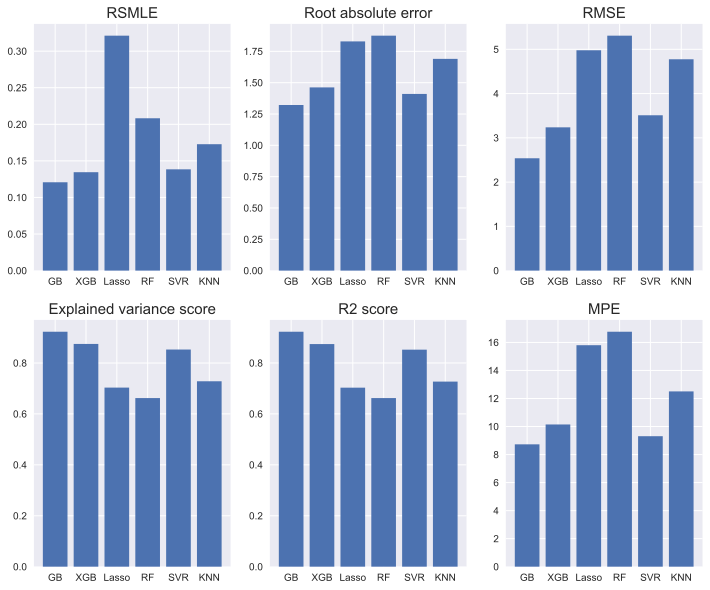

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

axes[0][0].bar(metrics_df['RSMLE'].index, list(metrics_df['RSMLE']))
axes[0][0].set_title('RSMLE', fontsize=15)
    
axes[0][1].bar(metrics_df['Root absolute error'].index, list(metrics_df['Root absolute error']))
axes[0][1].set_title('Root absolute error', fontsize=15)

axes[0][2].bar(metrics_df['RMSE'].index, list(metrics_df['RMSE']))
axes[0][2].set_title('RMSE', fontsize=15)

axes[1][0].bar(metrics_df['Explained variance score'].index, list(metrics_df['Explained variance score']))
axes[1][0].set_title('Explained variance score', fontsize=15)

axes[1][1].bar(metrics_df['R2 score'].index, list(metrics_df['R2 score']))
axes[1][1].set_title('R2 score', fontsize=15)

axes[1][2].bar(metrics_df['MPE'].index, list(metrics_df['MPE']))
axes[1][2].set_title('MPE', fontsize=15)

**Сравним предсказанные данные с реальными.**

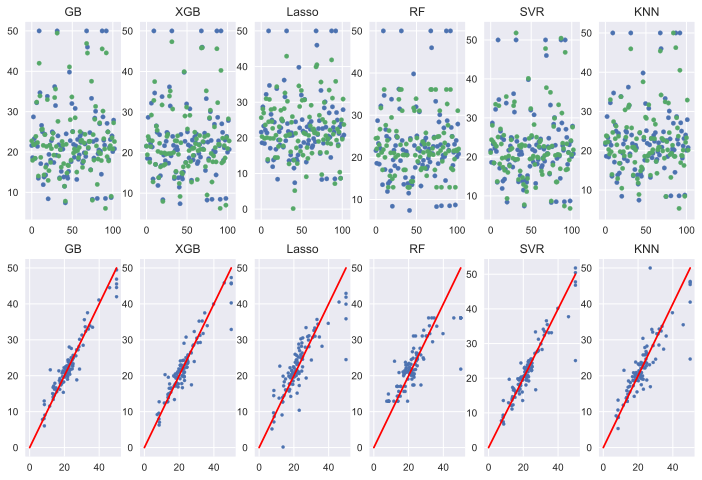

In [29]:
fig, axes = plt.subplots(2, 6, figsize=(12, 8))

for k in range(0, 6):
    axes[0][k].scatter(np.linspace(0, len(y_test), len(y_test)), y_test, s=20)
    axes[0][k].scatter(np.linspace(0, len(y_test), len(y_test)),  predicts[k], s=20)
    axes[0][k].set_title(index[k], fontsize=12)
    
    axes[1][k].scatter(y_test, predicts[k], s=10)
    axes[1][k].plot(np.linspace(0, y_test.max(), 2), np.linspace(0, y_test.max(), 2), color='red')
    axes[1][k].set_title(index[k], fontsize=12)

**Можно видеть, что у линейной регрессии и у KNN имеются заметные выбросы. У случайного леса разхождения по горизонтали.**

**Таким образом, лучшей моделью для нашей задачи оказался GradientBoostingRegressor из библиотеки sklearn.**